In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()


In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.functions import concat, col, lit, to_date

In [3]:
def castColumn(df, field, cast_type):
    return df \
        .withColumn(field + '_tmp', df[field].cast(cast_type)) \
        .drop(field) \
        .withColumnRenamed(field + '_tmp', field) 

In [83]:
def process_df(df):
    df = df \
        .filter(df.ArrDelay != "NA") \
        .filter(df.DepTime != "NA") \
        .filter(df.CRSDepTime != "NA") \
        .filter(df.CRSArrTime != "NA") \
        .withColumn('Date', to_date(concat(col("Year"), lit("-"), col("Month"), lit('-'), col('DayofMonth'))))
    df = castColumn(df, 'ArrDelay', 'int')
    df = castColumn(df, 'DepDelay', 'int')
    df = castColumn(df, 'CRSElapsedTime', 'int')
    df = castColumn(df, 'Distance', 'int')
    df = castColumn(df, 'TaxiOut', 'int')
    return df

In [85]:
df_small = spark.read.csv("../data/2007_small.csv",header=True)
df_big = spark.read.csv("../data/2007.csv",header=True)
df_massive = spark.read.csv("../data/2006.csv",header=True) \
                .union(df_big) \
                .union(spark.read.csv("../data/2008.csv",header=True))

df_small = process_df(df_small)
df_big = process_df(df_big)
df_massive = process_df(df_massive)


df_small.createOrReplaceTempView("df_small")
df_big.createOrReplaceTempView("df_big")
df_massive.createOrReplaceTempView("df_massive")

In [27]:
ad = pd.to_numeric(df_big.select("ArrDelay").filter(df_big.ArrDelay != "NA").toPandas()['ArrDelay'])

{'whiskers': [<matplotlib.lines.Line2D at 0x115c7a518>,
 'caps': [<matplotlib.lines.Line2D at 0x115c7aba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x115c7a128>],
 'medians': [<matplotlib.lines.Line2D at 0x115c7afd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1181c65c0>],
 'means': []}

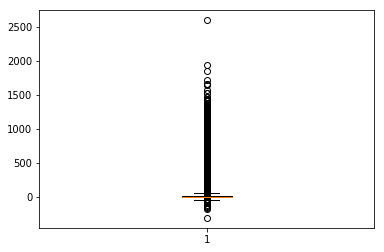

In [31]:
plt.boxplot(ad)

In [47]:
adg = spark.sql("select ArrDelay, count(*) from df_big where ArrDelay != 'NA' group by ArrDelay").toPandas()

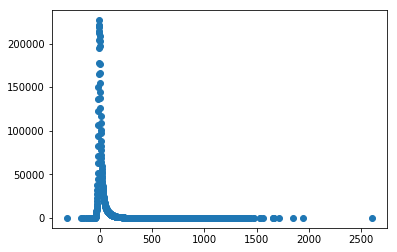

In [52]:
plt.scatter(pd.to_numeric(adg['ArrDelay']), adg['count(1)'])

In [55]:
print(np.mean(ad))
print(np.median(ad))

10.19218057072105
0.0


In [90]:
df_big.corr('DepDelay', 'ArrDelay')

0.9315028109819367

In [88]:
df_big.corr('CRSElapsedTime', 'ArrDelay')

0.0054417055786659735

In [87]:
df_big.corr('Distance', 'ArrDelay')

-0.0017171179099961672

In [89]:
df_big.corr('TaxiOut', 'ArrDelay')

0.3263614338001894

In [ ]:
df_small_pd['Month_cat'] = df_small_pd['Month'].astype('category')

TypeError: cannot perform reduce with flexible type

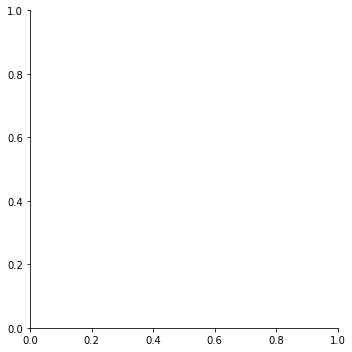

In [5]:
box_data = spark.sql('select Month, ArrDelay from df_big').toPandas()
sns.catplot(x="Month", y="ArrDelay", kind="box", data=box_data);

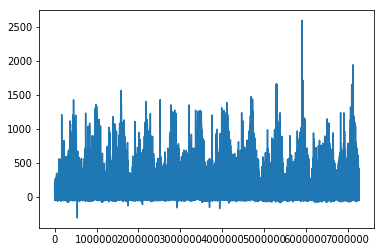

In [6]:
plt.plot(df_big.select('ArrDelay').toPandas()['ArrDelay'])

In [86]:
jan = spark.sql('select avg(ArrDelay), Date from df_massive group by Date order by Date asc').toPandas()

In [87]:
import datetime as dt

x = jan['Date']
y = jan['avg(ArrDelay)']

Populating the interactive namespace from numpy and matplotlib


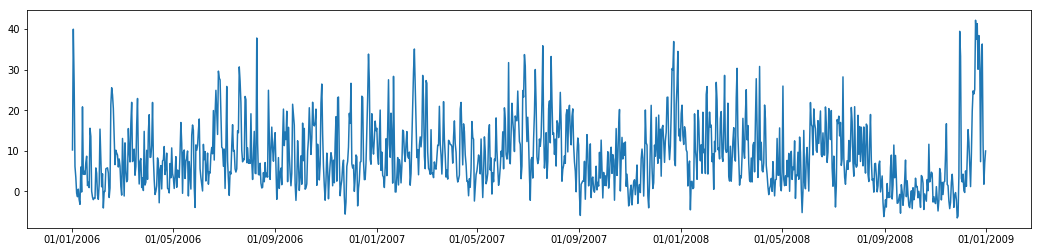

In [88]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 4)
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.plot(x,y)